<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #-----refesh python script-------#
# get_ipython().kernel.do_shutdown(restart=True)

# #----GPU Setup------#
# #Check GPUs
# !nvidia-smi

# #load cudf to use GPUs for analysis
# %load_ext cudf.pandas


#------Imports--------#
import pandas as pd
import datetime
import pickle
import numpy as np
import requests
import time
import os


#-------Froms-------#
from tqdm.notebook import tqdm
from datetime import datetime, timedelta


# #------Force Connect MyDrive-------#
# from google.colab import drive
# drive.mount('/content/drive')


# Stock Data

## Ensure the last 6 months of EODHD Data is available

In [2]:
# Ensure the last 6 months of EODHD Data is available
"""
Returns:
nasdaq_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 627225 entries, 0 to 627224
  Data columns (total 8 columns):
  #   Column          Non-Null Count   Dtype
  ---  ------          --------------   -----
  0   date            627225 non-null  datetime64[ns]
  1   ticker          627098 non-null  object
  2   open            627225 non-null  float64
  3   high            627225 non-null  float64
  4   low             627225 non-null  float64
  5   close           627225 non-null  float64
  6   adjusted_close  627225 non-null  float64
  7   volume          627225 non-null  float64
"""
#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")
else:
    print("⚠️ No new data fetched.")

# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

[1] Fetching 2025-06-12...
[2] Fetching 2025-06-13...
✅ Data for 5013 entries added to /content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv


## Get list of Tickers with Min Market Cap and populate screener_data_df

In [24]:
# Get list of Tickers with a min market cap and a list of common stocks
"""
Returns:
screener_data_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 262 entries, 0 to 261
  Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
  ---  ------                 --------------  -----
 0   code                   262 non-null    object
 1   name                   262 non-null    object
 2   last_day_data_date     262 non-null    object
 3   adjusted_close         262 non-null    float64
 4   refund_1d              262 non-null    float64
 5   refund_1d_p            262 non-null    float64
 6   refund_5d              262 non-null    float64
 7   refund_5d_p            262 non-null    float64
 8   exchange               262 non-null    object
 9   currency_symbol        262 non-null    object
 10  market_capitalization  262 non-null    int64
 11  earnings_share         262 non-null    float64
 12  dividend_yield         145 non-null    float64
 13  sector                 262 non-null    object
 14  industry               262 non-null    object
 15  avgvol_1d              262 non-null    int64
 16  avgvol_200d            262 non-null    float64
 17  Country                262 non-null    object
 18  Exchange               262 non-null    object
 19  Currency               262 non-null    object
 20  Type                   262 non-null    object
 21  last_day_change        262 non-null    float64

"""

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter to get screener_data_df
screener_data_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)

# Get exchange symbol list with type
meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock'].copy() # Add .copy() to avoid SettingWithCopyWarning

# Combine screener_data_df with relevant columns from common_df
screener_data_df = pd.merge(
    screener_data_df,
    common_df[['Code', 'Country', 'Exchange', 'Currency', 'Type']],
    left_on='code',
    right_on='Code',
    how='inner'
).drop('Code', axis=1)

# --- Calculate Daily Change ---

if 'nasdaq_df' in locals() and not nasdaq_df.empty:
    # Ensure date is datetime
    nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

    # Sort and calculate daily change on the original nasdaq_df
    temp_nasdaq_sorted = nasdaq_df.sort_values(by=['ticker', 'date']).copy()
    temp_nasdaq_sorted['daily_change'] = temp_nasdaq_sorted.groupby('ticker')['adjusted_close'].pct_change()

    # Get the last day's data from the temp sorted dataframe
    last_date = temp_nasdaq_sorted['date'].max()
    last_day_data = temp_nasdaq_sorted[temp_nasdaq_sorted['date'] == last_date]
    last_day_changes = last_day_data.set_index('ticker')['daily_change'].to_dict()

    # Append last_day_changes to screener_data_df
    screener_data_df['last_day_change'] = screener_data_df['code'].map(last_day_changes)
    # Fill potential NaN values if some tickers in screener_data_df didn't have data on the last day
    screener_data_df['last_day_change'] = screener_data_df['last_day_change'].fillna(0)
else:
    print("Warning: nasdaq_df not found or empty. Cannot calculate and append last_day_change.")

## Filter nasdaq data for screener_data_df and type: common

In [26]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

# Now filter nasdaq_df using the combined dataframe and type 'Common Stock'
filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(screener_data_df[screener_data_df['Type'] == 'Common Stock']['code'])
]

## Function: Correlation Coeficient for entire stock data set

In [27]:
#return six month and three month spearman correlations for all unique pairs of stocks

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    correlation_matrix: A pandas DataFrame with the following
      Index: Tickers
      Columns: Tickers
      Values: Spearman correlation coefficients between stocks
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix


In [28]:
# prompt: Can you check my Google drive for three_month_spearman_lagged_correlations and
# six_month_spearman_lagged_correlations first and pull in those CSVs if found. If not, run
# the calculate_lagged_correlation function and save these csvs as Today’s
# date_six_month_spearman_lagged_correlation and today’s date_three_month_spearman_lagged_correlation
"""
Returns:
  three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: Spearman correlation coefficients between stocks
"""
import pandas as pd
import os
from datetime import datetime

# Define the file paths in Google Drive
today_str = datetime.now().strftime('%Y%m%d')
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        # Save the newly calculated correlations to Google Drive
        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

One or both correlation files not found. Calculating correlations...


<ipython-input-27-784628608>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/262 [00:00<?, ?it/s]

<ipython-input-27-784628608>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/262 [00:00<?, ?it/s]

Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_three_month_spearman_lagged_correlation.csv
Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_six_month_spearman_lagged_correlation.csv


## Unified_Correlation

In [29]:
# prompt: Unified_Collelation
# use the six month correlation except if 3 month correlation is smaller.
# negative correlations are not used so this is not a concern
"""
Returns:
  unified_correlation_df: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: unified_correlation

"""

# A more concise way to implement the logic:
unified_correlation_df = three_month_spearman_lagged_correlations.where(
    (three_month_spearman_lagged_correlations > 0) & (six_month_spearman_lagged_correlations > 0)
).apply(
    lambda row: np.minimum(row, six_month_spearman_lagged_correlations.loc[row.name]),
    axis=1
).fillna(0)

## Process correlated Data and get prediction score

In [45]:
#reduces the number of correlations to only what will be displayed in the solar
# system based on a set of criteria outlined below
def process_and_score_stocks(
    correlation_df,
    six_month_correlations,
    three_month_correlations,
    screener_data_df,
    source_ticker, # Add source_ticker as an argument
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
):
    """
    Processes stock correlation data, filtering for top positive correlations,
    normalizing values for visualization, and calculating prediction scores
    for a specific source ticker.

    Args:
      correlation_df: DataFrame with unified correlation coefficients.
      six_month_correlations: The six-month spearman lagged correlation matrix.
      three_month_correlations: The three-month spearman lagged correlation matrix.
      screener_data_df: DataFrame containing at least 'code' (ticker),
                         'market_capitalization', and 'last_day_change' columns.
      source_ticker: The ticker symbol for which to process data and calculate the score.
      min_nodes: The minimum number of correlated stocks to return per source stock.
      max_nodes: The maximum number of correlated stocks to return per source stock.
      threshold_percent: A percentage (0.0 to 1.0) of the max correlation to use as a
                         filtering threshold.
      min_planet_size: The minimum radius for a planet in the visualization (default 0.1).
      max_planet_size: The maximum radius for a planet in the visualization (default 1.0).

    Returns:
      processed_data_df: A pandas DataFrame containing processed data for the source ticker
                         and its correlated stocks, including all requested columns.
                         Returns an empty DataFrame if no connections are found.
      prediction_score: The calculated prediction score for the source ticker.
                         Returns 0 if no connections are found.
    """
    # --- Data Unpivoting and Initial Setup ---
    correlation_df = correlation_df.rename_axis('ticker_a', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'unified_correlation'] # Renamed correlation to unified_correlation
    grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()
    grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['unified_correlation']**2

    # --- Filter for the specific source ticker and apply filtering logic ---
    source_connections = grouped_correlation_data[grouped_correlation_data['ticker_a'] == source_ticker].copy()

    if source_connections.empty:
        return pd.DataFrame(columns=[
            'source', 'target', 'unified_correlation', 'coefficient_of_determination',
            'six_month_spearman_correlation', 'three_month_spearman_correlation',
            'Orbital Radius', 'Market Cap', 'Planet Radius',
            'prediction_score (weight)', 'normalized_prediction_score (normalized weight)', 'Daily Change'
        ]), 0.0

    positive_corr_group = source_connections[source_connections['unified_correlation'] > 0].copy()
    if positive_corr_group.empty:
         return pd.DataFrame(columns=[
            'source', 'target', 'unified_correlation', 'coefficient_of_determination',
            'six_month_spearman_correlation', 'three_month_spearman_correlation',
            'Orbital Radius', 'Market Cap', 'Planet Radius',
            'prediction_score (weight)', 'normalized_prediction_score (normalized weight)', 'Daily Change'
        ]), 0.0


    max_correlation = positive_corr_group['unified_correlation'].max()
    threshold = max_correlation * threshold_percent
    filtered_group_df_threshold = positive_corr_group[positive_corr_group['unified_correlation'] >= threshold]

    if len(filtered_group_df_threshold) < min_nodes:
        most_correlated_stocks = positive_corr_group.sort_values(by='unified_correlation', ascending=False).head(min_nodes).copy()
    elif len(filtered_group_df_threshold) > max_nodes:
        most_correlated_stocks = filtered_group_df_threshold.sort_values(by='unified_correlation', ascending=False).head(max_nodes).copy()
    else:
        most_correlated_stocks = filtered_group_df_threshold.copy()

    # --- Add Six and Three Month Correlations ---
    most_correlated_stocks['six_month_spearman_correlation'] = most_correlated_stocks.apply(
        lambda row: six_month_correlations.loc[row['ticker_a'], row['ticker_b']] if row['ticker_a'] in six_month_correlations.index and row['ticker_b'] in six_month_correlations.columns else 0, axis=1
    )
    most_correlated_stocks['three_month_spearman_correlation'] = most_correlated_stocks.apply(
        lambda row: three_month_correlations.loc[row['ticker_a'], row['ticker_b']] if row['ticker_a'] in three_month_correlations.index and row['ticker_b'] in three_month_correlations.columns else 0, axis=1
    )


    # --- Normalization Logic for Visualization ---

    # Create dictionaries for fast lookups
    market_cap_dict = screener_data_df.set_index('code')['market_capitalization'].to_dict()
    last_day_changes_dict = screener_data_df.set_index('code')['last_day_change'].to_dict()

    # Get the overall min and max market caps for consistent scaling
    epsilon = 1e-9
    global_min_market_cap = screener_data_df['market_capitalization'].replace(0, epsilon).min()
    global_max_market_cap = screener_data_df['market_capitalization'].max()
    log_min_mc = np.log(global_min_market_cap)
    log_max_mc = np.log(global_max_market_cap)

    # Calculate min/max for unified_correlation normalization within this filtered group
    min_max_correlations = most_correlated_stocks['unified_correlation'].agg(['min', 'max'])


    def normalize_and_score_row(row, min_max_corr, market_cap_dict, last_day_changes_dict, log_min_mc, log_max_mc, min_planet_size, max_planet_size, epsilon):
        ticker_a = row['ticker_a']
        target_ticker = row['ticker_b']
        unified_correlation_val = row['unified_correlation']

        # --- Orbital Radius Calculation ---
        min_corr, max_corr = min_max_corr['min'], min_max_corr['max']
        orbital_radius = 0.0 if max_corr == min_corr else 1 - ((unified_correlation_val - min_corr) / (max_corr - min_corr))

        # --- Planet Radius Calculation ---
        market_cap = market_cap_dict.get(target_ticker, global_min_market_cap)
        market_cap = max(market_cap, epsilon)
        log_mc = np.log(market_cap)
        normalized_mc = 0.0 if log_max_mc == log_min_mc else (log_mc - log_min_mc) / (log_max_mc - log_min_mc)
        planet_radius = min_planet_size + (normalized_mc * (max_planet_size - min_planet_size))
        planet_radius = max(min_planet_size, min(planet_radius, max_planet_size)) # Ensure bounds

        # --- Prediction Score (Weight) Calculation ---
        market_cap_offset = 1e9 # Use the same offset as before
        log_market_cap_for_weight = np.log(market_cap + market_cap_offset) if market_cap > 0 else np.log(market_cap_offset)
        prediction_score_weight = (unified_correlation_val * log_market_cap_for_weight)

        # --- Daily Change ---
        daily_change = last_day_changes_dict.get(target_ticker, 0)

        return pd.Series([
            orbital_radius, market_cap, planet_radius,
            prediction_score_weight, daily_change * 100 # Convert daily change to percentage
        ], index=['Orbital Radius', 'Market Cap', 'Planet Radius', 'prediction_score (weight)', 'Daily Change'])

    # Apply the normalization and scoring function
    normalized_and_scored_values = most_correlated_stocks.apply(
        normalize_and_score_row,
        axis=1,
        args=(min_max_correlations, market_cap_dict, last_day_changes_dict, log_min_mc, log_max_mc, min_planet_size, max_planet_size, epsilon)
    )

    # Join the new columns to the main DataFrame
    processed_data_df = most_correlated_stocks.join(normalized_and_scored_values)

    # --- Calculate Normalized Prediction Score (Normalized Weight) and Total Prediction Score ---
    total_abs_weight = processed_data_df['prediction_score (weight)'].abs().sum()
    processed_data_df['normalized_prediction_score (normalized weight)'] = (
        (processed_data_df['prediction_score (weight)'] / total_abs_weight) * 100 if total_abs_weight else 0
    )

    # Apply the sign based on Daily Change to the normalized weight
    processed_data_df['normalized_prediction_score (normalized weight)'] = processed_data_df.apply(
        lambda row: row['normalized_prediction_score (normalized weight)'] if row['Daily Change'] >= 0 else -row['normalized_prediction_score (normalized weight)'],
        axis=1
    )

    # Calculate the overall prediction score for the source ticker
    prediction_score = processed_data_df['normalized_prediction_score (normalized weight)'].sum()


    # Final cleanup and renaming
    processed_data_df = processed_data_df.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

    # Select and reorder columns for the final output DataFrame
    final_columns = [
        'source', 'target', 'unified_correlation', 'coefficient_of_determination',
        'six_month_spearman_correlation', 'three_month_spearman_correlation',
        'Orbital Radius', 'Market Cap', 'Planet Radius',
        'prediction_score (weight)', 'normalized_prediction_score (normalized weight)', 'Daily Change'
    ]
    processed_data_df = processed_data_df[final_columns]


    return processed_data_df, prediction_score

In [ ]:
# --- MODIFIED: Run App ---
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

exclude_financials = True
range_months = 3
# Use a ticker from the top predictions list for demonstration, e.g., 'SEIC'
ticker = 'SEIC'
# Use the renamed variable here


correlation_df,
    six_month_correlations,
    three_month_correlations,
    screener_data_df,
    source_ticker, # Add source_ticker as an argument
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
processed_data_df, prediciton_score = process_and_score_stocks(
    unified_correlation_df,
    six_month
    screener_data_df,
    min_nodes,
    max_nodes,
    threshold_percent)


## Create Network Diagram

<ipython-input-68-645802890>:220: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



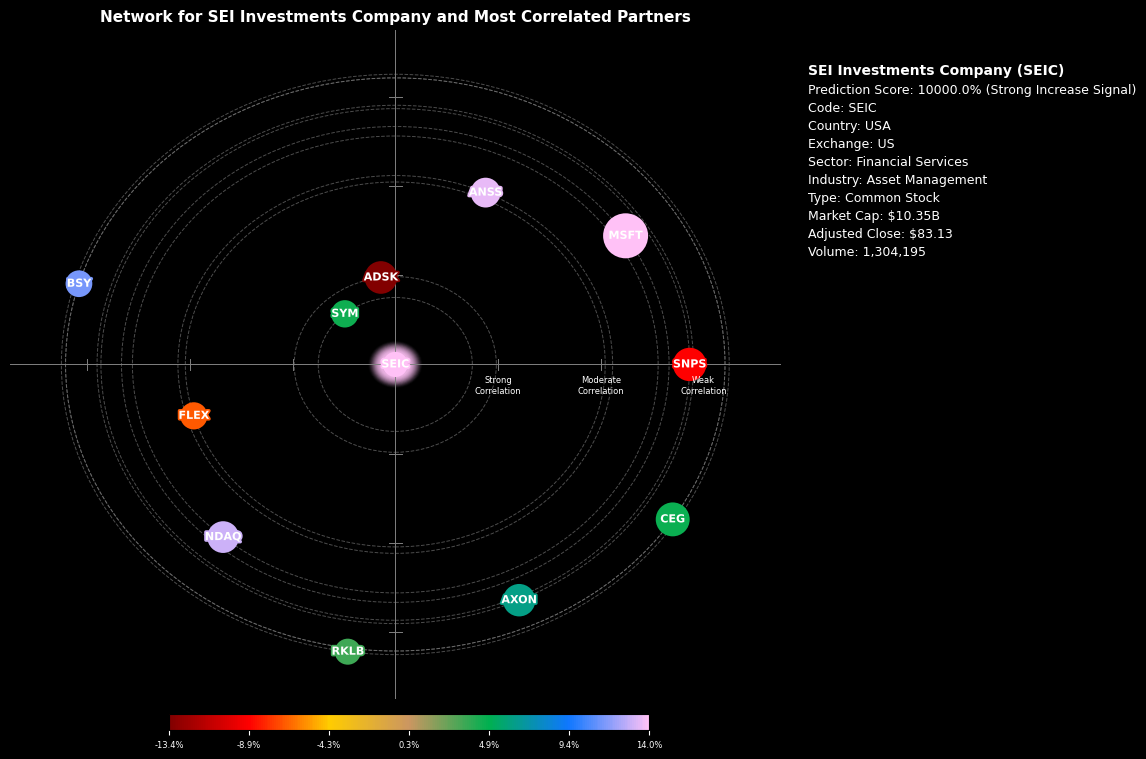

In [ ]:
# --- MODIFIED: Network Diagram Plotting Function ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions
import matplotlib.patheffects as path_effects # Import for text outline

def plot_ticker_network_visual(correlated_data, source_ticker, std_devs, screener_data_df, common_df, filtered_nasdaq_df, prediction_score, prediction_score_df):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    Includes a detailed information box for the source ticker.
    Takes the prediction_score (scalar) and the prediction_score_df.
    """
    # Filter for connections related to the source ticker
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    if source_ticker not in G:
        G.add_node(source_ticker)

    # Use subplots to have more control over the layout (graph on left, info on right)
    fig, (ax_main, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('black')
    ax_main.set_facecolor('black')
    ax_info.set_facecolor('black')

    # --- Reticle and Orbits on the main axis ---
    reticle_color = 'gray'
    ax_main.axhline(0, color=reticle_color, linestyle='-', linewidth=0.7)
    ax_main.axvline(0, color=reticle_color, linestyle='-', linewidth=0.7)

    radii = {'Strong': 0.4, 'Moderate': 0.8, 'Weak': 1.2}
    tick_length = 0.025

    for strength, r in radii.items():
        ax_main.plot([-tick_length, tick_length], [r, r], color=reticle_color, linewidth=0.7)
        ax_main.plot([-tick_length, tick_length], [-r, -r], color=reticle_color, linewidth=0.7)
        ax_main.plot([r, r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)
        ax_main.plot([-r, -r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)

    # Add labels for the reticle just below the tick marks on the positive x-axis
    label_offset_y = 0.05
    ax_main.text(radii['Strong'], -label_offset_y, 'Strong\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Moderate'], -label_offset_y, 'Moderate\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Weak'], -label_offset_y, 'Weak\nCorrelation', color='white', ha='center', va='top', fontsize=6)


    pos = {}
    pos[source_ticker] = (0, 0)

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)
        for i, target_node_name in enumerate(list(actual_target_connections['target'])):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']
            min_distance = 0.3
            current_orbital_radius = orbital_radius + min_distance

            orbit_patch = plt.Circle((0, 0), current_orbital_radius, fill=False, linestyle='--', edgecolor=reticle_color, linewidth=0.7, alpha=0.6)
            ax_main.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    # --- Node Sizing and Coloring ---
    min_planet_size, max_planet_size = 0.05, 1.5
    market_cap_dict = screener_data_df.set_index('code')['market_capitalization'].to_dict()
    epsilon = 1e-9
    global_min_market_cap = screener_data_df['market_capitalization'].replace(0, epsilon).min()
    global_max_market_cap = screener_data_df['market_capitalization'].max()
    log_min_mc, log_max_mc = np.log(global_min_market_cap), np.log(global_max_market_cap)

    source_market_cap = market_cap_dict.get(source_ticker, global_min_market_cap)
    source_market_cap = max(source_market_cap, epsilon)
    log_source_mc = np.log(source_market_cap)
    normalized_source_mc = 0.0 if log_max_mc == log_min_mc else (log_source_mc - log_min_mc) / (log_max_mc - log_min_mc)
    source_planet_radius = min_planet_size + (normalized_source_mc * (max_planet_size - min_planet_size))
    source_node_size = 300 + (source_planet_radius * 500)

    node_sizes_dict = {node: 300 + (ticker_connections[ticker_connections['target'] == node]['Planet Radius'].values[0] * 500) if node != source_ticker else source_node_size for node in G.nodes()}
    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Use normalized_weight from prediction_score_df for coloring ---
    colors = ['#820000', '#FF0000', '#FFCC00', '#CB9661', '#00B050', '#0E77FF', '#FFC1F6']
    cmap = mcolors.LinearSegmentedColormap.from_list('weight_cmap', colors)

    # Determine min/max weights for normalization to the colormap range (-1 to 1)
    all_weights = prediction_score_df['normalized_weight'].values
    min_weight, max_weight = np.min(all_weights), np.max(all_weights)
    norm_weights = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    node_colors_list = []
    # Ensure prediction_score is a scalar float
    prediction_score_scalar = float(prediction_score)
    for node in G.nodes():
        if node == source_ticker:
             # Color the source node based on the overall prediction score
            # Handle the case where prediction_score_scalar is 0 to avoid zero range in normalization
            if prediction_score_scalar == 0:
                norm_source = mcolors.Normalize(vmin=-1.0, vmax=1.0) # Use a default range around 0
            else:
                norm_source = mcolors.Normalize(vmin=min(0.0, prediction_score_scalar), vmax=max(0.0, prediction_score_scalar))
            source_node_color = cmap(norm_source(prediction_score_scalar))
            node_colors_list.append(source_node_color)
        else:
            # Color target nodes based on their signed normalized weight
            weight = prediction_score_df[prediction_score_df['ticker'] == node]['normalized_weight'].values
            if weight.size > 0:
                node_colors_list.append(cmap(norm_weights(weight[0])))
            else:
                # Default color if weight is not found (shouldn't happen with correct filtering)
                node_colors_list.append('gray')


    # --- Draw Aura and Nodes on the main axis ---
    aura_base_radius = np.sqrt(source_node_size / 300) * 0.05
    # Draw auras only for the source node
    for i in range(1, 15):
        aura = plt.Circle(pos[source_ticker], aura_base_radius * (1 + i * 0.07), color=source_node_color, alpha=0.3 * (1 - (i / 15)))
        ax_main.add_patch(aura)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=1.0, linewidths=0, ax=ax_main)

    # --- Draw Labels on the main axis ---
    node_color_map = dict(zip(G.nodes(), node_colors_list))
    for node in G.nodes():
        if node in pos:
            node_x, node_y = pos[node]
            node_color = node_color_map[node]
            txt = ax_main.text(node_x, node_y, str(node), color='white', fontweight='bold', fontsize=8, ha='center', va='center')
            txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color), path_effects.Normal()])

    # Fetch company name for the title
    company_name = screener_data_df[screener_data_df['code'] == source_ticker]['name'].values[0]
    ax_main.set_title(f'Network for {company_name} and Most Correlated Partners', color='white', fontsize=11, fontweight='bold')
    ax_main.axis('off')
    ax_main.set_xlim(-1.5, 1.5)
    ax_main.set_ylim(-1.5, 1.5)

    # --- NEW: Create Information Box on the right axis ---
    source_info_screener = screener_data_df[screener_data_df['code'] == source_ticker].iloc[0]
    source_info_eod = filtered_nasdaq_df[filtered_nasdaq_df['ticker'] == source_ticker].sort_values('date').iloc[-1]

    # Determine prediction score text
    if prediction_score >= 1.0:
        score_meaning = "Strong Increase Signal"
    elif prediction_score > 0.8:
        score_meaning = "Increase Signal"
    elif prediction_score > 0.5:
        score_meaning = "Weak Increase Signal"
    elif prediction_score <= -1.0:
        score_meaning = "Strong Decrease Signal"
    elif prediction_score > 0.9:
        score_meaning = "Increase Signal"
    elif prediction_score < -0.5:
        score_meaning = "Weak Decrease Signal"
    else:
        score_meaning = "Neutral/Mixed Signals"

    # Format Market Cap for readability
    market_cap = source_info_screener['market_capitalization']
    if market_cap > 1_000_000_000_000:
        market_cap_str = f"${market_cap/1_000_000_000_000:.2f}T"
    elif market_cap > 1_000_000_000:
        market_cap_str = f"${market_cap/1_000_000_000:.2f}B"
    else:
        market_cap_str = f"${market_cap/1_000_000:.2f}M"

    # Format the information string
    info_text = (
        f"Prediction Score: {prediction_score:.1%} ({score_meaning})\n"
        f"Code: {source_ticker}\n"
        f"Country: {screener_data_df[screener_data_df['code'] == source_ticker]['Country'].values[0]}\n"
        f"Exchange: {source_info_screener['exchange']}\n"
        f"Sector: {source_info_screener['sector']}\n"
        f"Industry: {source_info_screener['industry']}\n"
        f"Type: {screener_data_df[screener_data_df['code'] == source_ticker]['Type'].values[0]}\n"
        f"Market Cap: {market_cap_str}\n"
        f"Adjusted Close: ${source_info_eod['adjusted_close']:.2f}\n"
        f"Volume: {int(source_info_eod['volume']):,}"
    )

    # Add the text to the info axis, adjusting the y position to reduce the gap
    ax_info.text(0.05, 0.95, f"{company_name} ({source_ticker})", transform=ax_info.transAxes, fontsize=10, fontweight='bold', color='white', ha='left', va='top')
    ax_info.text(0.05, 0.92, info_text, transform=ax_info.transAxes, fontsize=9, color='white', ha='left', va='top', linespacing=1.5)
    ax_info.axis('off')

    # --- ADDED BACK: Add Colorbar Legend at the bottom of the main graph axis ---
    cbar_ax = fig.add_axes([0.145, 0.08, 0.4, 0.02]) # Adjusted position [left, bottom, width, height]
    # Use the same colormap and normalization as used for the target nodes
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_weights)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    # Set the ticks and labels for the colorbar based on the range of normalized weights
    cbar.set_ticks(np.linspace(min_weight, max_weight, 7))
    # Generate labels that represent the range of weights, formatted as percentages
    labels = [f'{val:.1f}%' for val in np.linspace(min_weight, max_weight, 7)]
    cbar.set_ticklabels(labels)

    # Style the colorbar labels
    cbar.ax.tick_params(colors='white', labelsize=6)


    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for colorbar
    plt.show()

# --- MODIFIED: Run App ---
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

exclude_financials = True
range_months = 3
# Use a ticker from the top predictions list for demonstration, e.g., 'SEIC'
ticker = 'SEIC'


# Use the renamed variable here
processed_data = process_stock_correlations(unified_correlation_df, screener_data_df, min_nodes, max_nodes, threshold_percent)
# Call calculate_prediction_score to get both the score and the DataFrame
prediction_score, prediction_score_df = calculate_prediction_score(ticker, processed_data, screener_data_df, std_devs)

# Pass the score and the prediction_score_df to the plotting function
plot_ticker_network_visual(processed_data, ticker, std_devs, screener_data_df, common_df, filtered_nasdaq_df, prediction_score, prediction_score_df)

In [33]:
# --- MODIFIED: Run App ---
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

exclude_financials = True
range_months = 3
# Use a ticker from the top predictions list for demonstration, e.g., 'SEIC'
ticker = 'SEIC'
# Use the renamed variable here
processed_data = process_stock_correlations(unified_correlation_df, screener_data_df, min_nodes, max_nodes, threshold_percent)


In [40]:
# Call calculate_prediction_score to get both the score and the DataFrame
prediction_score, prediction_score_df = calculate_prediction_score(ticker, processed_data, screener_data_df)


In [44]:
prediction_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticker             11 non-null     object 
 1   normalized_weight  11 non-null     float64
dtypes: float64(1), object(1)
memory usage: 308.0+ bytes


##Breakdown

In [ ]:
# prompt: Could you breakdown the ticker prediction score? I wan to understand why it got the score it did. List the contributions in order from most impactful to least. Add a percentage on how much this contribution impacted the prediction score. Make sure to add the weight, unified_correlation, six_month_spearman_correlation, three_month_spearman_correlation, market cap, daily_change, and volatility.

import pandas as pd
import numpy as np
def explain_prediction_score(source_ticker, prediction_score_df, six_month_correlations, three_month_correlations, screener_data_df):
    """
    Explains the breakdown of the prediction score for a given ticker, listing
    contributions from correlated stocks in order of impact (absolute weight).
    Includes unified correlation, six/three month correlations, market cap,
    daily change, and volatility for each contributing ticker.

    Args:
        source_ticker: The ticker symbol for which the score is explained.
        prediction_score_df: DataFrame from calculate_prediction_score
                             containing 'ticker' and 'normalized_weight'.
        six_month_correlations: The six-month spearman lagged correlation matrix.
        three_month_correlations: The three-month spearman lagged correlation matrix.
        screener_data_df: DataFrame containing 'code', 'market_capitalization', and 'last_day_change'.
        std_devs: Dictionary of ticker -> 6-month volatility (std deviation). # Note: std_devs is not currently used in this function but kept for potential future use.

    Returns:
        A pandas DataFrame detailing the contributions of each correlated stock
        to the prediction score, sorted by the absolute value of their weight.
    """

    # Filter for the contributions related to the source ticker
    # We will rebuild the contributions_list from scratch to ensure consistency
    # source_contributions = prediction_score_df.copy() # No longer needed

    # We need the list of target tickers from the prediction_score_df to know which connections to explain
    target_tickers = prediction_score_df['ticker'].tolist()


    if not target_tickers:
        print(f"No contributions found for ticker {source_ticker}.")
        return pd.DataFrame()

    contributions_list = []
    market_cap_dict = screener_data_df.set_index('code')['market_capitalization'].to_dict()
    last_day_changes_dict = screener_data_df.set_index('code')['last_day_change'].to_dict()
    market_cap_offset = 1e9 # Use the same offset

    # First pass to calculate original weights and the total absolute original weight
    original_weights_data = []
    for target_ticker in target_tickers:
        # Retrieve correlations
        six_month_corr = six_month_correlations.loc[source_ticker, target_ticker] if source_ticker in six_month_correlations.index and target_ticker in six_month_correlations.columns else 0
        three_month_corr = three_month_correlations.loc[source_ticker, target_ticker] if source_ticker in three_month_correlations.index and target_ticker in three_month_correlations.columns else 0

        # Calculate unified correlation as defined in the preceding code
        unified_corr = 0
        if three_month_corr > 0 and six_month_corr > 0:
            unified_corr = min(three_month_corr, six_month_corr)

        # Get market cap
        market_cap = market_cap_dict.get(target_ticker, 0)
        log_market_cap = np.log(market_cap + market_cap_offset) if market_cap > 0 else np.log(market_cap_offset) # Handle zero market cap

        # Calculate original weight
        original_weight = (unified_corr * log_market_cap)
        original_weights_data.append({'ticker': target_ticker, 'original_weight': original_weight})

    original_weights_df = pd.DataFrame(original_weights_data)
    total_abs_original_weight = original_weights_df['original_weight'].abs().sum()

    # Second pass to build the final contributions DataFrame with all details
    for _, row in original_weights_df.iterrows():
        target_ticker = row['ticker']
        original_weight = row['original_weight']

        # Get Daily Change and Volatility
        daily_change = last_day_changes_dict.get(target_ticker, 0)
        # volatility = std_devs.get(target_ticker, 0) # Volatility is not currently used in the breakdown table

        # Calculate Normalized Original Weight (%)
        normalized_original_weight = (original_weight / total_abs_original_weight) * 100

        # Calculate Normalized Weight (%) - Magnitude from Normalized Original Weight, sign from Daily Change
        normalized_weight_magnitude = abs(normalized_original_weight)
        normalized_weight_signed = normalized_weight_magnitude if daily_change >= 0 else -normalized_weight_magnitude


        # Retrieve correlations again for the final table
        six_month_corr = six_month_correlations.loc[source_ticker, target_ticker] if source_ticker in six_month_correlations.index and target_ticker in six_month_correlations.columns else 0
        three_month_corr = three_month_correlations.loc[source_ticker, target_ticker] if source_ticker in three_month_correlations.index and target_ticker in three_month_correlations.columns else 0
        unified_corr = 0
        if three_month_corr > 0 and six_month_corr > 0:
            unified_corr = min(three_month_corr, six_month_corr)

        # Get market cap again for the final table
        market_cap = market_cap_dict.get(target_ticker, 0)


        contributions_list.append({
            'ticker': target_ticker,
            'Normalized Weight (%)': normalized_weight_signed, # Use the newly calculated signed weight
            'Unified Correlation': unified_corr,
            'Six Month Spearman Correlation': six_month_corr,
            'Three Month Spearman Correlation': three_month_corr,
            'Market Cap': market_cap,
            'Daily Change (%)': daily_change * 100, # Convert to percentage
            'Original Weight (Unified * Log(MC))': original_weight, # Keep for context
            'Normalized Original Weight (%)': normalized_original_weight # Keep for comparison
        })

    contributions_df = pd.DataFrame(contributions_list)

    # Sort by the absolute value of the Normalized Weight (%) from most to least impactful
    contributions_df = contributions_df.sort_values(by='Normalized Weight (%)', key=abs, ascending=False).reset_index(drop=True)

    # Format columns for better readability
    contributions_df['Market Cap'] = contributions_df['Market Cap'].apply(
        lambda x: f"${x/1_000_000_000:.2f}B" if x >= 1_000_000_000 else (f"${x/1_000_000:.2f}M" if x >= 1_000_000 else f"${x:.2f}")
    )
    contributions_df['Normalized Weight (%)'] = contributions_df['Normalized Weight (%)'].map('{:.2f}%'.format)
    contributions_df['Normalized Original Weight (%)'] = contributions_df['Normalized Original Weight (%)'].map('{:.2f}%'.format)
    contributions_df['Daily Change (%)'] = contributions_df['Daily Change (%)'].map('{:.2f}%'.format)
    contributions_df['Unified Correlation'] = contributions_df['Unified Correlation'].map('{:.4f}'.format)
    contributions_df['Six Month Spearman Correlation'] = contributions_df['Six Month Spearman Correlation'].map('{:.4f}'.format)
    contributions_df['Three Month Spearman Correlation'] = contributions_df['Three Month Spearman Correlation'].map('{:.4f}'.format)
    contributions_df['Original Weight (Unified * Log(MC))'] = contributions_df['Original Weight (Unified * Log(MC))'].map('{:.4f}'.format)


    return contributions_df

# --- Call the explanation function and display the result ---

# Assuming 'ticker', 'prediction_score_df', 'six_month_spearman_lagged_correlations',
# 'three_month_spearman_lagged_correlations', 'screener_data_df', 'last_day_changes',
# and 'std_devs' are defined from the preceding code execution.

print(f"\nDetailed breakdown for {ticker}'s Prediction Score:")
explanation_df = explain_prediction_score(
    ticker,
    prediction_score_df,
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
)

if not explanation_df.empty:
    display(explanation_df)


Detailed breakdown for ZS's Prediction Score:


,ticker,Normalized Weight (%),Unified Correlation,Six Month Spearman Correlation,Three Month Spearman Correlation,Market Cap,Daily Change (%),Original Weight (Unified * Log(MC)),Normalized Original Weight (%)
0,AXON,18.84%,0.6067,0.6067,0.9386,$60.60B,2.06%,15.0736,18.84%
1,NDAQ,14.66%,0.4759,0.4759,0.9147,$49.83B,0.84%,11.7315,14.66%
2,MSFT,13.56%,0.3757,0.3757,0.9488,$3512.77B,0.36%,10.8524,13.56%
3,CEG,10.28%,0.3259,0.3259,0.9363,$91.21B,0.40%,8.2291,10.28%
4,BSY,8.87%,0.3023,0.3023,0.8783,$14.64B,0.65%,7.0951,8.87%
5,FLEX,-8.76%,0.2973,0.2973,0.9303,$16.29B,-0.50%,7.0083,8.76%
6,SYM,8.52%,0.2888,0.2888,0.9259,$16.98B,2.02%,6.8192,8.52%
7,ADSK,-5.78%,0.1858,0.1858,0.9401,$63.49B,-0.26%,4.6247,5.78%
8,RKLB,4.40%,0.1508,0.1508,0.8945,$12.62B,0.70%,3.5182,4.40%
9,SNPS,-3.63%,0.1156,0.1156,0.8539,$77.69B,-0.73%,2.9009,3.63%


In [ ]:
prediction_score_df

,ticker,normalized_weight
0,ADSK,-13.447960
1,ANSS,13.543801
2,AXON,6.218654
3,BSY,11.441847
4,CEG,4.622373
5,FLEX,-6.885194
6,MSFT,14.021379
7,NDAQ,13.034164
8,RKLB,3.423872
9,SNPS,-8.841222


##List of Top Predictions

In [ ]:
# prompt: Generate a list of the top prediction scores. This should be a list of the ticker and the prediction score. The prediction score should be larger than 95% and sort them by greatest to least

import pandas as pd
from tqdm import tqdm # Import tqdm for the progress bar
# Calculate prediction scores for all tickers in the processed data
all_tickers = processed_data['source'].unique().tolist()
prediction_scores = []

for ticker in tqdm(all_tickers, desc="Calculating Prediction Scores"):
    # calculate_prediction_score returns a tuple (score, prediction_score_df)
    score, _ = calculate_prediction_score(ticker, processed_data, screener_data_df, std_devs)
    prediction_scores.append({'ticker': ticker, 'score': score})

# Create a DataFrame from the scores
prediction_df = pd.DataFrame(prediction_scores)

# Filter for scores greater than 95%
high_prediction_df = prediction_df[prediction_df['score'] > 0].copy()

# Sort the filtered DataFrame by score in descending order
sorted_high_predictions = high_prediction_df.sort_values(by='score', ascending=False)

# Convert the sorted DataFrame to a list of dictionaries
top_predictions_list = sorted_high_predictions.to_dict('records')

# Print the list of top predictions
print("\nTop Prediction Scores, sorted high to low:")
for item in top_predictions_list:
    print(f"  {item['ticker']}: {item['score']:.2f}")

Calculating Prediction Scores: 100%|██████████| 261/261 [00:00<00:00, 316.62it/s]


Top Prediction Scores, sorted high to low:
  SEIC: 44.82
  EXE: 40.79
  MSTR: 25.47
  MELI: 23.35
  DUOL: 23.33
  CYBR: 22.09
  ESLT: 21.96
  NFLX: 21.83
  EBAY: 21.43
  PFG: 20.74
  PAA: 20.38
  RPRX: 18.56
  WING: 10.91
  DASH: 9.80
  ALNY: 4.08
  RIVN: 3.88
  RYAAY: 3.66
  SNY: 3.29
  ASTS: 3.06
  BKNG: 3.05
  ZS: 2.83
  NTES: 2.74
  ULTA: 2.59
  ASND: 2.56
  TTWO: 2.27
  CME: 1.41
  INTC: 1.20
  NVDA: 0.68
  STLD: 0.39
  RKLB: 0.17
  AXON: 0.07


#Dash App

In [ ]:
# Install necessary libraries (run this cell first)
!pip install -q dash dash-bootstrap-components plotly

In [ ]:
from dash import Dash, html # Import the main Dash class to create our application.
import os # Import os to set environment variables for ngrok.
from pyngrok import ngrok # Import ngrok from pyngrok to create a public tunnel.
from google.colab import userdata # Import userdata to access Colab secrets

# --- Configure Ngrok for public access ---
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN

# Define the port your Dash app will run on.
DASH_PORT = 8050

# Create a public ngrok tunnel to the specified port. This will generate a
# public URL that you can access from anywhere, including your iPad, bypassing Colab's iframe restrictions.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"Your Dash app will be accessible at: {public_url}")

# --- Initialize the Dash application ---
app = Dash(__name__)

# --- Define the app layout ---
app.layout = html.Div([
    html.H1("Welcome to the Finacial Observatory!", style={'textAlign': 'center', 'color': 'blue'}),
    html.P("I love you, Nix!", style={'textAlign': 'center', 'color': 'green'})
])

# --- Run the Dash server ---
print(f"Starting Dash server on port {DASH_PORT}...")
app.run(debug=True, port=DASH_PORT)

# Important Note:
# Keep this Colab notebook cell running and active for your app to remain live.
# If the Colab runtime disconnects or the cell execution stops, your app will go offline.

Establishing Ngrok tunnel...
Your Dash app will be accessible at: NgrokTunnel: "https://0456-34-83-174-46.ngrok-free.app" -> "http://localhost:8050"
Starting Dash server on port 8050...


<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok

# Kills all ngrok processes that pyngrok started
print("Attempting to kill all active ngrok tunnels...")
ngrok.kill()
print("All ngrok tunnels should now be terminated.")

Attempting to kill all active ngrok tunnels...
All ngrok tunnels should now be terminated.


In [ ]:
# --- Import necessary libraries ---
from dash import Dash, html, dcc, Input, Output # We need dcc for interactive components and Input/Output for callbacks
import os
from pyngrok import ngrok
from google.colab import userdata

# --- Configure Ngrok for public access ---
# This part remains the same to create a public URL for your app
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN
except userdata.SecretNotFoundError:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
    # You might want to handle this case, e.g., by exiting or using a default token if applicable
    exit()


# Define the port your Dash app will run on.
DASH_PORT = 8051

# Create a public ngrok tunnel to the specified port.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"🚀 Your Dash app will be accessible at: {public_url}")

# --- Initialize the Dash application ---
app = Dash(__name__)

# --- Define the app layout ---
# The layout is what the user sees. We've added an input box and a div for the output.
app.layout = html.Div([
    html.H1("Simple Interactive App", style={'textAlign': 'center', 'color': '#4A90E2'}),

    html.P("Type something in the box below:", style={'textAlign': 'center'}),

    # dcc.Input is an interactive component that allows user text input.
    dcc.Input(
        id='user-input-box',      # A unique ID to identify this component in callbacks
        type='text',               # The type of input (text, number, password, etc.)
        placeholder='Enter your message here...', # Placeholder text
        style={'width': '50%', 'padding': '10px', 'margin': 'auto', 'display': 'block'}
    ),

    # This html.Div will be used to display the output from our callback.
    # It starts empty.
    html.Div(
        id='app-output-div',
        style={'textAlign': 'center', 'marginTop': '20px', 'fontSize': '24px', 'color': '#50E3C2'}
    )
])

# --- Define the Callback ---
# This is the core of the app's interactivity.
# It connects the input component to the output component.
@app.callback(
    Output('app-output-div', 'children'), # The component property we want to update (the content of the div)
    Input('user-input-box', 'value')      # The component property that triggers the callback (the value of the input box)
)
def update_output_div(input_value):
    """
    This function is called automatically by Dash whenever the 'value' of the 'user-input-box' changes.
    The new value is passed as the 'input_value' argument.
    The function's return value is used to update the 'children' of the 'app-output-div'.
    """
    if input_value is None or input_value == '':
        return "Type something to get a response!"
    else:
        # The f-string creates a new string with the user's input.
        return f'The app says: "{input_value}"'

# --- Run the Dash server ---
print(f"Starting Dash server on port {DASH_PORT}...")
# The host='0.0.0.0' is important for running in environments like Colab
app.run(debug=True, port=DASH_PORT)

# Important Note:
# Keep this Colab notebook cell running and active for your app to remain live.
# If the Colab runtime disconnects or the cell execution stops, your app will go offline.


Establishing Ngrok tunnel...
🚀 Your Dash app will be accessible at: NgrokTunnel: "https://bf60-34-83-174-46.ngrok-free.app" -> "http://localhost:8051"
Starting Dash server on port 8051...


<IPython.core.display.Javascript object>

In [ ]:
# Display descriptive statistics of the calculated scores
print("Descriptive statistics of prediction scores:")
display(prediction_df['score'].describe())

# Display the first few rows of the prediction_df to see sample scores
print("\nSample of calculated prediction scores:")
display(prediction_df.head())

# Check the maximum score to see if it's close to the threshold
max_score = prediction_df['score'].max()
print(f"\nMaximum prediction score: {max_score:.2f}")

# Check how many scores are above 95
count_above_95 = (prediction_df['score'] > 95).sum()
print(f"\nNumber of tickers with score > 95: {count_above_95}")

Descriptive statistics of prediction scores:


,score
count,261.000000
mean,-41.240832
std,29.504366
min,-100.000000
25%,-62.365173
50%,-40.785424
75%,-23.796721
max,44.134355



Sample of calculated prediction scores:


,ticker,score
0,AAPL,-2.079788
1,ABNB,-73.324077
2,ACGL,1.388236
3,ADBE,-70.945344
4,ADI,-83.863688



Maximum prediction score: 44.13

Number of tickers with score > 95: 0
